# <ins>Song Lyrics Through the Years</ins>

# Webscraping

### Using BeautifulSoup and [LyricsGenius](https://github.com/johnwmillr/LyricsGenius)

- This notebook (and the associated [functions file](functions/webscraping.py)) details my process for scraping (and re-scraping) yearly song lyrics from songs that made it into the Top 10 on the Billboard. I used [Top 40 Weekly](https://top40weekly.com/) to find the songs to scrape from [Genius](https://genius.com). 
- Some songs were not available via Genius so were scraped via other lyrics sites.

#### Important note
I'm more deeply understanding the imperfection behind the art and science of textscraping. As a result, there is a lot of rescraping that was necessary here, much of which could be built into the original scrape. Since that scrape took nearly two hours to complete, I've decided to move on for now, as I'm happy with the data set I've produced. After completing the project, I will ideally find the time to optimize the webscraping process from the beginning.

Thank you for understanding :)

## Table of contents

1. [Import necessary packages](#Import-necessary-packages)
2. [Initial scrape](#Initial-scrape)

    - [Song title and artist](#Song-title-and-artist)
    - [Lyrics](#Lyrics)
    - [💾 Initial Save/Load  💾](#💾-Initial-Save/Load--💾)


3. [Rescrape](#Rescrape)

    - [1960s](#1960)
    - [1970s](#1970)
    - [1980s](#1980)
    - [1990s](#1990)
    - [2000s](#2000)
    - [2010s](#2010)
    

4. [Initial data cleaning](#Initial-data-cleaning)

    - [💾 Final Save/Load  💾](#💾-Final-Save/Load--💾)
    

5. [Take a look at song quantities over the years](#Take-a-look-at-song-quantities-over-the-years)

6. [Next notebook: Data Cleaning](#Next-notebook:-Data-Cleaning)
    
## Import necessary packages

[[go back to the top](#Song-Lyrics-Through-the-Years)]

In [1]:
import pandas as pd; pd.options.display.max_rows = 200
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

import re
from unicodedata import normalize

import requests as rq
from bs4 import BeautifulSoup as bs
from selenium import webdriver

import pickle
import gzip

from functions.webscraping import *

import json

%load_ext autoreload
%autoreload 2

## Initial scrape

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- First I need to use [Top 40 Weekly](https://top40weekly.com/) to find the song titles that I want to scrape.
- I'm also scraping the artist name(s) though I doubt I will end up needing that for this project.
- The year is more imputed than it is scraped, but will be vital to the aims of this project.

### Song title and artist

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- Iterate over each year between 1960 and 2019, collecting each unique song that appears in the Top 10 that year.

In [2]:
%%time

# list of unique songs in top 10 between 1960 and 2019
all_top10s = [
    yearly_top10s(f'https://top40weekly.com/{year}-all-charts/') for year in range(1960,2020)
]

# confirm 60 years
len(all_top10s)

CPU times: user 14.7 s, sys: 195 ms, total: 14.9 s
Wall time: 1min 51s


60

In [3]:
# number of songs, before removing some duplicates across years
sum([len(year) for year in all_top10s])

5293

- Save the list, just in case ;)

In [4]:
# # uncomment to save
# with gzip.open('data/all_top10s.pkl', 'wb') as goodbye:
#     pickle.dump(all_top10s, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/all_top10s.pkl', 'rb') as hello:
#     all_top10s = pickle.load(hello)

- Since some songs may be within the top 10 in two (or more) different years, I need to remove those from the list.

In [5]:
# list to append song dictionaries
top10s = []

# iterate over each year
for i,year in enumerate(all_top10s):
    
    # iterate over each song
    for song in year:
        
        # compile year, title, and artist and add those to the above list
        ## NOTE: here is where i could separate "main" artist(s) from "featured" artist(s), ##
        ## as well as replace any "and"s with "&"s ##
        song_dict = {}
        song_dict['year'] = i+1960
        song_dict['title'] = song[0]
        song_dict['artist'] = song[1]
        top10s.append(song_dict)

In [6]:
# convert list of dictionaries to dataframe
temp_df = pd.DataFrame(top10s) 

# drop any rows with the same title and artist (regardless of year)
temp_df = temp_df.drop_duplicates(subset=['title', 'artist'])

# convert back to a list of dictionaries
unique_top10s = temp_df.to_dict('records')

In [7]:
# check new number of songs
len(unique_top10s)

4735

### Lyrics

[[go back to the top](#Song-Lyrics-Through-the-Years)]

In [8]:
# parse personal api keys
with open('data/api_keys.json', 'r') as json_file:
    creds = json.load(json_file)

# set the credentials based on the credentials file
client_id = creds['client_id']
client_secret = creds['client_secret']
access_token = creds['access_token']

In [9]:
%%time

# list to append song dictionaries
top10s = []

# start print log
print('Failed grabs:')

# iterate over each dictionary
for song in unique_top10s:
    
    # string to search on Genius.com
    search_term = f"{song['title']} {song['artist']}"
        
    try:
        # call api, add lyrics to dictionary
        song['lyrics'] = lyrics_grabber(access_token, search_term)

    except:
        # if that throws an error
        try:
            # take only letters, commas, periods, and spaces, and the first two words in the artist title
            ## NOTE: splitting main artist from featured artist(s) may render this redundant ##
            search_term = f"{re.match('[A-Z,. ]+', song['title']).group()} {' '.join(song['artist'].split()[:2])}"
            
            # call api with new search, add lyrics to dictionary
            song['lyrics'] = lyrics_grabber(access_token, search_term)

        except:
            # add to log if that still throws an error
            print(search_term)
            # also insert nan into lyrics key of dictionary
            song['lyrics'] = np.nan
    
    # add dictionary to list
    top10s.append(song)

# confirm number of songs
len(top10s)

Failed grabs:
(Down At) PAPA JOE’S The Dixiebelles
AN OPEN LETTER TO MY TEENAGE SON Victor Lundberg
/ 14 DOWN ON THE CORNER / FORTUNATE SON Creedence Clearwater Revival
Timeout raised and caught:
HTTPSConnectionPool(host='genius.com', port=443): Read timed out. (read timeout=5)
MIDNIGHT COWBOY Ferrante and
JUNGLE FEVER The Chakachas
YOU AIN Bachman-Turner Overdrive
JUJU ON DAT BEAT  Zayion McCall
CPU times: user 5min 53s, sys: 15.4 s, total: 6min 9s
Wall time: 1h 57min 57s


4735

In [10]:
# convert to dataframe
df = pd.DataFrame(top10s)

# check shape
df.shape

(4735, 4)

In [11]:
# check first five rows
df.head()

,year,title,artist,lyrics
0,1960,THE VILLAGE OF ST. BERNADETTE,Andy Williams,"I've traveled far, the land and the sea\nBeaut..."
1,1960,PAPER ROSES,Anita Bryant,I realize the way your eyes deceived me\nWith ...
2,1960,IN MY LITTLE CORNER OF THE WORLD,Anita Bryant,"Oh, come along with me\nTo my little corner of..."
3,1960,O DIO MIO,Annette,"[Strofa 1]\nE un giorno lui mi disse: ""Nei tuo..."
4,1960,WONDERLAND BY NIGHT,Bert Kaempfert,Stars hang suspended\nAbove a floating yellow ...


In [12]:
# check last five rows
df.tail()

,year,title,artist,lyrics
4730,2019,YOU NEED TO CALM DOWN,Taylor Swift,[Verse 1]\nYou are somebody that I don't know\...
4731,2019,ME!,Taylor Swift featuring Brendon Urie,"JANUARY""Giant"" by Calvin Harris featuring Rag ..."
4732,2019,HEARTLESS,The Weeknd,"[Intro]\nYoung Metro, young Metro, young Metro..."
4733,2019,DANCE MONKEY,Tones and I,"[Verse 1]\nThey say, ""Oh my God, I see the way..."
4734,2019,HIGHEST IN THE ROOM,Travis Scott,[Chorus]\nI got room in my fumes (Yeah)\nShe f...


### 💾 Initial Save/Load  💾

[[go back to the top](#Song-Lyrics-Through-the-Years)]

In [14]:
# # uncomment to save
# with gzip.open('data/lyrics_df.pkl', 'wb') as goodbye:
#     pickle.dump(df, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/lyrics_df.pkl', 'rb') as hello:
#     df = pickle.load(hello)

## Rescrape

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- Due to some idiosyncracies in Genius's search bar, some of which are bound to happen, I checked each year for any signs of badly scraped lyrics.
- In the future, I hope to optimize the initial scrape to render much of this useless, though I doubt it would ever be perfect.

### 1960

[[go back to the top](#Song-Lyrics-Through-the-Years)]

In [50]:
# rescrape
df.loc[32, 'lyrics'] = lyrics_grabber(access_token, search_term="because they're young duane eddy and the rebels")
df.loc[51, 'lyrics'] = lyrics_grabber(access_token, search_term='jackie wilson night')
df.loc[68, 'lyrics'] = lyrics_grabber(access_token, search_term='mister custer')
df.loc[75, 'lyrics'] = lyrics_grabber(access_token, search_term='the big hurt toni fisher')
df.loc[85, 'lyrics'] = lyrics_grabber(access_token, search_term='Only the Lonely (Know the Way I Feel)')


# more complex ones
soup = soupify('https://www.flashlyrics.com/lyrics/lolita/sailor-your-home-is-the-sea-41')
df.loc[69, 'lyrics'] = '\n'.join(
    [line.contents[0] for line in soup.find('div', attrs={'class': 'main-panel-content'}).find_all('span')
     if line.contents][2:]
)

soup = soupify('https://www.flashlyrics.com/lyrics/the-ivy-three/yogi-79')
df.loc[98, 'lyrics'] = '\n'.join(
    [line.contents[0] for line in soup.find('div', attrs={'class': 'main-panel-content'}).find_all('span')
     if line.contents]
)

In [52]:
# remove lines
df.loc[45, 'lyrics'] = remove_n_lines(df.loc[45, 'lyrics'], 11)

In [53]:
# instrumentals
df.loc[38, 'lyrics'] = np.nan
df.loc[39, 'lyrics'] = np.nan
df.loc[81, 'lyrics'] = np.nan
df.loc[102, 'lyrics'] = np.nan

### 1961

In [80]:
# rescrape
df.loc[106, 'lyrics'] = lyrics_grabber(access_token, 'arthur lyman yellow bird')
df.loc[136, 'lyrics'] = rescrape('https://www.lyricsondemand.com/d/dickanddeedeelyrics/themountainshighlyrics.html',
                                 name='div', attrs={'class': 'lcontent'})
df.loc[174, 'lyrics'] = lyrics_grabber(access_token, "ral donner you don't know what you've got")

# more complex ones
soup = soupify('https://www.flashlyrics.com/lyrics/adam-wade/as-if-i-didnt-know-55')
df.loc[105, 'lyrics'] = '\n'.join(
    [line.contents[0] for line in soup.find('div', attrs={'class': 'main-panel-content'}).find_all('span')
     if line.contents]
)

soup = soupify('https://www.flashlyrics.com/lyrics/ferrante-and-teicher/tonight-12')
df.loc[144, 'lyrics'] = '\n'.join(
    [line.contents[0] for line in soup.find('div', attrs={'class': 'main-panel-content'}).find_all('span')
     if line.contents]
)

In [81]:
# instrumentals
df.loc[110, 'lyrics'] = np.nan
df.loc[145, 'lyrics'] = np.nan
df.loc[161, 'lyrics'] = np.nan
df.loc[185, 'lyrics'] = np.nan
df.loc[198, 'lyrics'] = np.nan

In [82]:
# remove lines
df.loc[105, 'lyrics'] = remove_n_lines(df.loc[105, 'lyrics'], 2)
df.loc[174, 'lyrics'] = remove_n_lines(df.loc[174, 'lyrics'], 5)
df.loc[195, 'lyrics'] = remove_n_lines(df.loc[195, 'lyrics'], 10)
df.loc[208, 'lyrics'] = remove_n_lines(df.loc[208, 'lyrics'], 3)

In [83]:
# update song
df.loc[177, 'title'] = 'Corrine, Corrina'

In [85]:
# remove duplicate
df.drop(index=178, inplace=True)
df.drop(index=182, inplace=True)

### 1962

In [100]:
# rescrape
df.loc[272, 'lyrics'] = lyrics_grabber(access_token, 'joey dee shout')

In [101]:
# instrumentals
df.loc[214, 'lyrics'] = np.nan
df.loc[215, 'lyrics'] = np.nan
df.loc[221, 'lyrics'] = np.nan
df.loc[241, 'lyrics'] = np.nan
df.loc[242, 'lyrics'] = np.nan
df.loc[276, 'lyrics'] = np.nan
df.loc[282, 'lyrics'] = np.nan
df.loc[315, 'lyrics'] = np.nan
df.loc[316, 'lyrics'] = np.nan

In [102]:
# remove lines
df.loc[226, 'lyrics'] = remove_n_lines(df.loc[226, 'lyrics'], 7, 3)
df.loc[256, 'lyrics'] = remove_n_lines(df.loc[256, 'lyrics'], 2)
df.loc[273, 'lyrics'] = remove_n_lines(df.loc[273, 'lyrics'], 5, 1)
df.loc[318, 'lyrics'] = remove_n_lines(df.loc[318, 'lyrics'], 2)

### 1963

In [110]:
# rescrape
df.loc[360, 'lyrics'] = lyrics_grabber(access_token, 'fingertips stevie')

# more complex ones
soup = soupify('https://www.flashlyrics.com/lyrics/dixie-belles/down-at-papa-joes-70')
df.loc[403, 'lyrics'] = '\n'.join(
    [line.contents[0] for line in soup.find('div', attrs={'class': 'main-panel-content'}).find_all('span')
     if line.contents][1:]
)

In [111]:
# instrumentals
df.loc[324, 'lyrics'] = np.nan
df.loc[353, 'lyrics'] = np.nan
df.loc[361, 'lyrics'] = np.nan
df.loc[362, 'lyrics'] = np.nan
df.loc[397, 'lyrics'] = np.nan
df.loc[419, 'lyrics'] = np.nan

In [112]:
# remove lines
df.loc[327, 'lyrics'] = remove_n_lines(df.loc[327, 'lyrics'], 3)
df.loc[344, 'lyrics'] = remove_n_lines(df.loc[344, 'lyrics'], 2)
df.loc[351, 'lyrics'] = remove_n_lines(df.loc[351, 'lyrics'], 2)

### 1964

In [117]:
# rescrape
df.loc[442, 'lyrics'] = lyrics_grabber(access_token, 'summer song chad')
df.loc[473, 'lyrics'] = lyrics_grabber(access_token, 'dancing in the street martha')
df.loc[482, 'lyrics'] = lyrics_grabber(access_token, 'roy orbison pretty woman')
df.loc[518, 'lyrics'] = rescrape('http://www.songlyrics.com/the-larks/jerk-lyrics/',
                                 name='p', attrs={'class': 'songLyricsV14 iComment-text'})

In [118]:
# instrumentals
df.loc[431, 'lyrics'] = np.nan
df.loc[519, 'lyrics'] = np.nan
df.loc[534, 'lyrics'] = np.nan

In [119]:
# remove lines
df.loc[513, 'lyrics'] = remove_n_lines(df.loc[513, 'lyrics'], 6)
df.loc[521, 'lyrics'] = remove_n_lines(df.loc[521, 'lyrics'], 6)

In [120]:
# update artist name
df.loc[442, 'artist'] = 'Chad and Jeremy'

In [121]:
# remove duplicate
df.drop(index=467, inplace=True)

### 1965

In [124]:
# rescrape
df.loc[562, 'lyrics'] = lyrics_grabber(access_token, "Papa’s Got a Brand New Bag (Part 1)")
df.loc[571, 'lyrics'] = lyrics_grabber(access_token, 'nowhere to run martha')
df.loc[593, 'lyrics'] = lyrics_grabber(access_token, 'i got you babe')
df.loc[611, 'lyrics'] = lyrics_grabber(access_token, "I Can’t Help Myself (Sugar Pie, Honey Bunch)")

In [125]:
# instrumentals
df.loc[552, 'lyrics'] = np.nan
df.loc[621, 'lyrics'] = np.nan

### 1966

In [131]:
# rescrape
df.loc[689, 'lyrics'] = lyrics_grabber(access_token, 'good thing paul revere')
df.loc[691, 'lyrics'] = lyrics_grabber(access_token, 'hungry paul revere')
df.loc[692, 'lyrics'] = lyrics_grabber(access_token, 'kicks paul revere')
df.loc[694, 'lyrics'] = lyrics_grabber(access_token, 'lady godiva peter')
df.loc[704, 'lyrics'] = lyrics_grabber(access_token, 'homeward bound simon')
df.loc[735, 'lyrics'] = lyrics_grabber(access_token, 'california dreamin')

In [132]:
# remove duplicate
df.drop(index=690, inplace=True)

### 1967

In [135]:
# rescrape
df.loc[874, 'lyrics'] = rescrape('http://www.songlyrics.com/victor-lundberg/an-open-letter-to-my-teenage-son-lyrics/',
                                 name='p', attrs={'class': 'songLyricsV14 iComment-text'})

### 1968

In [145]:
# rescrape
df.loc[929, 'lyrics'] = lyrics_grabber(access_token, 'mrs. robinson')

In [146]:
# instrumentals
df.loc[888, 'lyrics'] = np.nan
df.loc[904, 'lyrics'] = np.nan
df.loc[905, 'lyrics'] = np.nan
df.loc[919, 'lyrics'] = np.nan

In [140]:
# remove lines
df.loc[899, 'lyrics'] = remove_n_lines(df.loc[899, 'lyrics'], 3, 7)
df.loc[969, 'lyrics'] = remove_n_lines(df.loc[969, 'lyrics'], 5, 1)

### 1969

- There are some top 10 entries that appear as both the single's A and B sides.
- I'll split these up into two separate entries.

In [191]:
%%time

# instantiate empty list
to_add_on = []

# exclude final entry because it is actually a single song
# loop over indices, overwrite row with first song, capture second song
for ind in df[df.title.str.contains(' / ')].index[:-1]:
    second_song = split_combos(df, ind)
    to_add_on.append(second_song)

# convert second songs to dataframe
temp_df = pd.DataFrame(to_add_on)

# combine
df = pd.concat([df, temp_df])

Timeout raised and caught:
HTTPSConnectionPool(host='genius.com', port=443): Read timed out. (read timeout=5)
CPU times: user 8.58 s, sys: 402 ms, total: 8.98 s
Wall time: 4min 9s


In [155]:
# rescrape
df.loc[1003, 'lyrics'] = lyrics_grabber(access_token, 'i want you back the jackson 5')
df.loc[1023, 'lyrics'] = lyrics_grabber(access_token, 'boxer simon garfunkel')
df.loc[1039, 'lyrics'] = lyrics_grabber(access_token, 'beatles get back')

In [156]:
# instrumentals
df.loc[981, 'lyrics'] = np.nan
df.loc[982, 'lyrics'] = np.nan
df.loc[1001, 'lyrics'] = np.nan
df.loc[1057, 'lyrics'] = np.nan
df.loc[1071, 'lyrics'] = np.nan

In [157]:
# remove duplicate
df.drop(index=1038, inplace=True)

### 1970

[[go back to the top](#Song-Lyrics-Through-the-Years)]

In [169]:
# rescrape
df.loc[1111, 'lyrics'] = lyrics_grabber(access_token, 'abc the jackson 5')
df.loc[1130, 'lyrics'] = lyrics_grabber(access_token, 'cecilia simon garfunkel')
df.loc[1131, 'lyrics'] = lyrics_grabber(access_token, 'bridge over troubled water simon garfunkel')

### 1971

In [197]:
df.reset_index(drop=True, inplace=True)

In [203]:
# rescrape
df.loc[1172, 'lyrics'] = lyrics_grabber(access_token, 'one toke over the line brewer & shipley')
df.loc[1220, 'lyrics'] = lyrics_grabber(access_token, 'uncle albert')

In [204]:
# edge case, had a slash in song title
df.loc[1225, 'title'] = 'UNCLE ALBERT/ADMIRAL HALSEY'

In [205]:
# instrumentals
df.loc[1183, 'lyrics'] = np.nan

In [206]:
# remove duplicate
df.drop(index=4751, inplace=True)
df.drop(index=4754, inplace=True)

### 1972

In [209]:
# rescrape
df.loc[1337, 'lyrics'] = lyrics_grabber(access_token, 'jungle fever chakachas')

In [210]:
# instrumentals
df.loc[1267, 'lyrics'] = np.nan
df.loc[1275, 'lyrics'] = np.nan
df.loc[1303, 'lyrics'] = np.nan

# edge case; non-lyric song
df.loc[1339, 'lyrics'] = np.nan

In [211]:
# remove duplicate
df.drop(index=1287, inplace=True)

### 1973

In [215]:
# rescrape
df.loc[1412, 'lyrics'] = lyrics_grabber(access_token, 'The Morning After (Theme From The Poseidon Adventure)')

In [216]:
# instrumentals
df.loc[1432, 'lyrics'] = np.nan

# edge case; non-lyric song
df.loc[1392, 'lyrics'] = np.nan

### 1974

In [222]:
# rescrape
df.loc[1497, 'lyrics'] = lyrics_grabber(access_token, 'use my imagination gladys')
df.loc[1515, 'lyrics'] = lyrics_grabber(access_token, 'hollywood swinging')
df.loc[1516, 'lyrics'] = lyrics_grabber(access_token, 'jungle boogie')
df.loc[1531, 'lyrics'] = lyrics_grabber(access_token, 'jet wings')
df.loc[1534, 'lyrics'] = lyrics_grabber(access_token, 'band on the run wings')

In [223]:
# instrumentals
df.loc[1521, 'lyrics'] = np.nan
df.loc[1522, 'lyrics'] = np.nan
df.loc[1553, 'lyrics'] = np.nan
df.loc[4757, 'lyrics'] = np.nan

### 1975

In [229]:
# rescrape
df.loc[1592, 'lyrics'] = lyrics_grabber(access_token, 'shining star earth')
df.loc[1658, 'lyrics'] = lyrics_grabber(access_token, 'yesterday carpenters')
df.loc[1660, 'lyrics'] = lyrics_grabber(access_token, 'philadelphia freedom elton john')
df.loc[1663, 'lyrics'] = lyrics_grabber(access_token, 'fire ohio players')
df.loc[1664, 'lyrics'] = lyrics_grabber(access_token, 'love rollercoaster ohio players')
df.loc[1641, 'lyrics'] = lyrics_grabber(access_token, 'ringo no no song')

In [230]:
# instrumentals
df.loc[1629, 'lyrics'] = np.nan
df.loc[1669, 'lyrics'] = np.nan

### 1976

In [233]:
# rescrape
df.loc[1686, 'lyrics'] = lyrics_grabber(access_token, 'sara smile hall oates')
df.loc[1694, 'lyrics'] = lyrics_grabber(access_token, 'sing a song earth')
df.loc[1730, 'lyrics'] = lyrics_grabber(access_token, 'disco duck rick dees')
df.loc[1738, 'lyrics'] = lyrics_grabber(access_token, 'more more more andrea true')
df.loc[1746, 'lyrics'] = lyrics_grabber(access_token, 'muskrat love')

In [234]:
# instrumentals
df.loc[1729, 'lyrics'] = np.nan
df.loc[1758, 'lyrics'] = np.nan

### 1977

In [242]:
# rescrape
df.loc[1777, 'lyrics'] = lyrics_grabber(access_token, 'bill conti gonna fly now')
df.loc[1843, 'lyrics'] = lyrics_grabber(access_token, 'jet airliner steve miller')
df.loc[1844, 'lyrics'] = lyrics_grabber(access_token, 'eagle steve miller')

In [243]:
# instrumentals
df.loc[1819, 'lyrics'] = np.nan
df.loc[1841, 'lyrics'] = np.nan
df.loc[4769, 'lyrics'] = np.nan

In [244]:
# remove lines
df.loc[1803, 'lyrics'] = remove_n_lines(df.loc[1803, 'lyrics'], 2)

### 1978

In [248]:
# rescrape
df.loc[1867, 'lyrics'] = lyrics_grabber(access_token, 'still the same bob seger')
df.loc[1922, 'lyrics'] = lyrics_grabber(access_token, 'ymca village people')

In [249]:
# instrumentals
df.loc[1873, 'lyrics'] = np.nan

### 1979

In [253]:
# rescrape
df.loc[1950, 'lyrics'] = lyrics_grabber(access_token, 'after the love has gone earth')
df.loc[1951, 'lyrics'] = lyrics_grabber(access_token, 'september earth')
df.loc[1952, 'lyrics'] = lyrics_grabber(access_token, 'boogie wonderland')
df.loc[1957, 'lyrics'] = lyrics_grabber(access_token, 'promises eric clapton')
df.loc[1958, 'lyrics'] = lyrics_grabber(access_token, 'watch out for lucy eric clapton')
df.loc[1964, 'lyrics'] = lyrics_grabber(access_token, 'only lonely souther')

In [254]:
# update title
df.loc[1958, 'title'] = 'WATCH OUT FOR LUCY'

In [255]:
# instrumentals
df.loc[1960, 'lyrics'] = np.nan
df.loc[1962, 'lyrics'] = np.nan

In [256]:
# remove duplicates
df.drop(index=4771, inplace=True)
df.drop(index=4772, inplace=True)

### 1980

[[go back to the top](#Song-Lyrics-Through-the-Years)]

In [261]:
# rescrape
df.loc[2068, 'lyrics'] = lyrics_grabber(access_token, 'another brick in the wall')

In [262]:
# instrumentals
df.loc[4775, 'lyrics'] = np.nan

In [264]:
# remove lines
df.loc[2024, 'lyrics'] = remove_n_lines(df.loc[2024, 'lyrics'], 3)
df.loc[2054, 'lyrics'] = remove_n_lines(df.loc[2054, 'lyrics'], 3)

In [265]:
# remove duplicate
df.drop(index=2064, inplace=True)
df.drop(index=4773, inplace=True)
df.drop(index=4774, inplace=True)
df.drop(index=4776, inplace=True)

### 1981

In [272]:
# rescrape
df.loc[2112, 'lyrics'] = lyrics_grabber(access_token, "let's groove earth")
df.loc[2122, 'lyrics'] = lyrics_grabber(access_token, 'joey scarbury believe it or not')

In [273]:
# instrumentals
df.loc[2135, 'lyrics'] = np.nan

In [274]:
# remove lines
df.loc[2103, 'lyrics'] = remove_n_lines(df.loc[2103, 'lyrics'], 6)

### 1982

In [277]:
# rescrape
df.loc[2189, 'lyrics'] = lyrics_grabber(access_token, 'crimson and clover')
df.loc[2190, 'lyrics'] = lyrics_grabber(access_token, 'Joan Jett & The Blackhearts i love rock')
df.loc[2231, 'lyrics'] = lyrics_grabber(access_token, 'rock this town stray cats')

In [278]:
# instrumentals
df.loc[2202, 'lyrics'] = np.nan
df.loc[2235, 'lyrics'] = np.nan

### 1983

In [284]:
# rescrape
df.loc[2242, 'lyrics'] = lyrics_grabber(access_token, 'shame on the moon bob seger')
df.loc[2292, 'lyrics'] = lyrics_grabber(access_token, 'say say say paul')
df.loc[2306, 'lyrics'] = lyrics_grabber(access_token, 'sweet dreams eurythmics')

In [285]:
# remove lines
df.loc[2302, 'lyrics'] = remove_n_lines(df.loc[2302, 'lyrics'], 8)

In [286]:
# remove duplicate
df.drop(index=2205, inplace=True)

### 1984

In [290]:
# rescrape
df.loc[2393, 'lyrics'] = lyrics_grabber(access_token, 'warrior scandal')
df.loc[2402, 'lyrics'] = lyrics_grabber(access_token, 'state of shock jacksons')

### 1985

In [293]:
# instrumentals
df.loc[2451, 'lyrics'] = np.nan
df.loc[2456, 'lyrics'] = np.nan

In [294]:
# remove lines
df.loc[2477, 'lyrics'] = remove_n_lines(df.loc[2477, 'lyrics'], 1)

### 1986

In [297]:
# rescrape
df.loc[2583, 'lyrics'] = lyrics_grabber(access_token, 'your wildest dreams')

### 1987

In [300]:
# rescrape
df.loc[2646, 'lyrics'] = lyrics_grabber(access_token, 'war bruce springsteen')
df.loc[2712, 'lyrics'] = lyrics_grabber(access_token, 'got the look prince')
df.loc[2714, 'lyrics'] = lyrics_grabber(access_token, 'the one i love rem')

In [301]:
# instrumentals
df.loc[2689, 'lyrics'] = np.nan

### 1988 - 1989

In [306]:
# rescrape
df.loc[2785, 'lyrics'] = lyrics_grabber(access_token, 'anything for you gloria')
df.loc[2809, 'lyrics'] = lyrics_grabber(access_token, "she's like the wind patrick swayze")

### 1990

[[go back to the top](#Song-Lyrics-Through-the-Years)]

In [315]:
# rescrape
df.loc[3054, 'lyrics'] = lyrics_grabber(access_token, 'this old heart of mine rod')

In [316]:
# remove lines
df.loc[3060, 'lyrics'] = remove_n_lines(df.loc[3060, 'lyrics'], 3)
df.loc[3068, 'lyrics'] = remove_n_lines(df.loc[3068, 'lyrics'], 1)

### 1991 - 1993

In [38]:
# rescrape
df.loc[3264, 'lyrics'] = lyrics_grabber(access_token, 'janet jackson again')

In [324]:
# remove lines
df.loc[3273, 'lyrics'] = remove_n_lines(df.loc[3273, 'lyrics'], 6)

### 1994

In [327]:
# remove lines
df.loc[4778, 'lyrics'] = remove_n_lines(df.loc[4778, 'lyrics'], 2)

### 1995

In [335]:
# rescrape
df.loc[3372, 'lyrics'] = lyrics_grabber(access_token, "gangsta's paradise coolio")
df.loc[3401, 'lyrics'] = lyrics_grabber(access_token, 'big poppa')
df.loc[4781, 'lyrics'] = lyrics_grabber(access_token, 'childhood michael jackson')

### 1996

In [339]:
# rescrape
df.loc[3443, 'lyrics'] = lyrics_grabber(access_token, 'nobody keith sweat')
df.loc[4784, 'lyrics'] = lyrics_grabber(access_token, 'how do u want it 2pac')

In [340]:
# remove lines
df.loc[3422, 'lyrics'] = remove_n_lines(df.loc[3422, 'lyrics'], 3)

In [341]:
# instrumentals
df.loc[3417, 'lyrics'] = np.nan

### 1997

In [345]:
# rescrape
df.loc[3485, 'lyrics'] = lyrics_grabber(access_token, 'mmmbop')
df.loc[3495, 'lyrics'] = lyrics_grabber(access_token, 'feel so good ma$e')
df.loc[3501, 'lyrics'] = lyrics_grabber(access_token, "i'll be missing you puff daddy")
df.loc[3503, 'lyrics'] = lyrics_grabber(access_token, 'CAN’T NOBODY HOLD ME DOWN')
df.loc[4790, 'lyrics'] = lyrics_grabber(access_token, 'been around the world puff')

### 1998

In [43]:
# rescrape
df.loc[3557, 'lyrics'] = lyrics_grabber(access_token, 'lookin at me ma$e')

In [352]:
# remove lines
df.loc[3564, 'lyrics'] = remove_n_lines(df.loc[3564, 'lyrics'], 4)

In [353]:
# remove duplicates
df.drop(index=3540, inplace=True)
df.drop(index=4791, inplace=True)

### 1999

In [357]:
# rescrape
df.loc[3604, 'lyrics'] = lyrics_grabber(access_token, 'lost in you garth')
df.loc[3632, 'lyrics'] = lyrics_grabber(access_token, 'smooth santana')

### 2000

[[go back to the top](#Song-Lyrics-Through-the-Years)]

In [362]:
# rescrape
df.loc[3663, 'lyrics'] = lyrics_grabber(access_token, "destiny's child independent")
df.loc[3683, 'lyrics'] = lyrics_grabber(access_token, 'case of the ex')
df.loc[3687, 'lyrics'] = lyrics_grabber(access_token, 'country grammer nelly')
df.loc[3695, 'lyrics'] = lyrics_grabber(access_token, 'maria santana')

In [363]:
# remove duplicate
df.drop(index=3696, inplace=True)

### 2001

In [367]:
# rescrape
df.loc[3711, 'lyrics'] = lyrics_grabber(access_token, "lady marmalade Lil’ Kim, Mýa, Christina Aguilera & P!nk")
df.loc[3726, 'lyrics'] = lyrics_grabber(access_token, 'always on time ja rule')
df.loc[3728, 'lyrics'] = lyrics_grabber(access_token, 'put it on me ja rule')

In [370]:
# remove duplicate
df.drop(index=3736, inplace=True)

### 2002

In [377]:
# rescrape
df.loc[3771, 'lyrics'] = lyrics_grabber(access_token, 'oh boy cam’ron')
df.loc[3772, 'lyrics'] = lyrics_grabber(access_token, 'hey ma cam’ron')
df.loc[3784, 'lyrics'] = lyrics_grabber(access_token, "what's luv fat joe")
df.loc[3785, 'lyrics'] = lyrics_grabber(access_token, 'down 4 u ja rule')
df.loc[3807, 'lyrics'] = lyrics_grabber(access_token, 'diddy i need a girl (pt. 2)')
df.loc[3808, 'lyrics'] = lyrics_grabber(access_token, 'diddy i need a girl (pt. 1)')

In [378]:
# remove lines
df.loc[3766, 'lyrics'] = remove_n_lines(df.loc[3766, 'lyrics'], 4)

### 2003

In [390]:
# rescrape
df.loc[3824, 'lyrics'] = lyrics_grabber(access_token, '21 questions 50 cent')
df.loc[3831, 'lyrics'] = lyrics_grabber(access_token, 'crazy in love beyonce')
df.loc[3836, 'lyrics'] = lyrics_grabber(access_token, 'holidae in chingy')
df.loc[3842, 'lyrics'] = lyrics_grabber(access_token, 'into you fabolous')
df.loc[3854, 'lyrics'] = lyrics_grabber(access_token, 'get low lil jon')
df.loc[3856, 'lyrics'] = lyrics_grabber(access_token, 'ludacris stand up')
df.loc[3862, 'lyrics'] = lyrics_grabber(access_token, 'way you move outkast')
df.loc[3869, 'lyrics'] = lyrics_grabber(access_token, 'beautiful snoop dog')
df.loc[3872, 'lyrics'] = lyrics_grabber(access_token, 'damn youngbloodz')

### 2004

In [399]:
# rescrape
df.loc[3886, 'lyrics'] = lyrics_grabber(access_token, 'goodies ciara')
df.loc[3887, 'lyrics'] = lyrics_grabber(access_token, 'my band d12')
df.loc[3898, 'lyrics'] = lyrics_grabber(access_token, 'slow motion juvenile')
df.loc[3899, 'lyrics'] = lyrics_grabber(access_token, 'all falls down kanye')
df.loc[3902, 'lyrics'] = lyrics_grabber(access_token, 'lovers and friend lil jon')
df.loc[3918, 'lyrics'] = lyrics_grabber(access_token, 'drop it snoop')
df.loc[3926, 'lyrics'] = lyrics_grabber(access_token, 'yeah usher')

### 2005

In [407]:
# featuring rescrapes
to_be_rescraped = [3931, 3938, 3941, 3956, 3967, 3976, 3977]

for ind in to_be_rescraped:
    df.loc[ind, 'lyrics'] = featuring(df, ind, access_token)

In [408]:
# rescrape
df.loc[3984, 'lyrics'] = lyrics_grabber(access_token, 'my humps black')

In [409]:
# remove lines
df.loc[3934, 'lyrics'] = remove_n_lines(df.loc[3934, 'lyrics'], 4)

### 2006

In [414]:
# featuring rescrapes
to_be_rescraped = [3986, 3987, 3990, 3994, 4002, 4004, 4009, 4024, 4030, 4041]

for ind in to_be_rescraped:
    df.loc[ind, 'lyrics'] = featuring(df, ind, access_token)

In [415]:
# rescrape
df.loc[4051, 'lyrics'] = lyrics_grabber(access_token, 'breaking free')

### 2007

In [426]:
# featuring rescrapes
to_be_rescraped = [4053, 4089, 4106, 4111, 4117]

for ind in to_be_rescraped:
    df.loc[ind, 'lyrics'] = featuring(df, ind, access_token)

In [427]:
# rescrape
df.loc[4073, 'lyrics'] = lyrics_grabber(access_token, 'feist 1234')
df.loc[4075, 'lyrics'] = lyrics_grabber(access_token, 'fergie big girls')
df.loc[4086, 'lyrics'] = lyrics_grabber(access_token, 'justin what goes around')

### 2008

In [436]:
# featuring rescrapes
to_be_rescraped = [4131, 4145, 4147, 4148, 4149, 4168, 4170]

for ind in to_be_rescraped:
    df.loc[ind, 'lyrics'] = featuring(df, ind, access_token)

In [437]:
# rescrape
df.loc[4136, 'lyrics'] = lyrics_grabber(access_token, 'no air jordin')
df.loc[4173, 'lyrics'] = lyrics_grabber(access_token, 'independent webbie')

### 2009

In [442]:
# featuring rescrapes
to_be_rescraped = [4183, 4193, 4224]

for ind in to_be_rescraped:
    df.loc[ind, 'lyrics'] = featuring(df, ind, access_token)

In [443]:
# rescrape
df.loc[4183, 'lyrics'] = lyrics_grabber(access_token, 'sexy bitch david')
df.loc[4197, 'lyrics'] = lyrics_grabber(access_token, 'run this town jay-z')
df.loc[4230, 'lyrics'] = lyrics_grabber(access_token, 'boom boom pow black')
df.loc[4231, 'lyrics'] = lyrics_grabber(access_token, 'i gotta feeling black')

### 2010

[[go back to the top](#Song-Lyrics-Through-the-Years)]

In [453]:
# featuring rescrapes
to_be_rescraped = [4235, 4236, 4237, 4244, 4255, 4261, 4268, 4269, 4271, 4274, 4275, 4276, 4279]

for ind in to_be_rescraped:
    df.loc[ind, 'lyrics'] = featuring(df, ind, access_token)

### 2011

In [459]:
# featuring rescrapes
to_be_rescraped = [4289, 4292, 4293, 4294, 4295, 4302, 4311, 4325, 4326]

for ind in to_be_rescraped:
    df.loc[ind, 'lyrics'] = featuring(df, ind, access_token)

In [460]:
# rescrape
df.loc[4305, 'lyrics'] = lyrics_grabber(access_token, 'niggas in paris')

In [461]:
# remove lines
df.loc[4312, 'lyrics'] = remove_n_lines(df.loc[4312, 'lyrics'], 3)
df.loc[4313, 'lyrics'] = remove_n_lines(df.loc[4313, 'lyrics'], 1)

### 2012

In [467]:
# featuring rescrapes
to_be_rescraped = [4336, 4340, 4341, 4347, 4350, 4351, 4358, 4376]

for ind in to_be_rescraped:
    df.loc[ind, 'lyrics'] = featuring(df, ind, access_token)

### 2013

In [476]:
# featuring rescrapes
to_be_rescraped = [4380, 4382, 4387, 4392, 4394, 4399, 4405, 4407, 4408, 4420, 4423, 4425]

for ind in to_be_rescraped:
    df.loc[ind, 'lyrics'] = featuring(df, ind, access_token)

In [477]:
# rescrape
df.loc[4379, 'lyrics'] = lyrics_grabber(access_token, 'fuckin problems A$AP Rocky')
df.loc[4381, 'lyrics'] = lyrics_grabber(access_token, 'cups anna kendrick')

In [474]:
# update artist
df.loc[4379, 'artist'] = 'A$AP Rocky featuring Drake, 2 Chainz & Kendrick Lamar'

In [482]:
# remove duplicate
df.drop(index=4421, inplace=True)

### 2014

In [488]:
# featuring rescrapes
to_be_rescraped = [4431, 4432, 4438, 4439, 4442, 4447, 4448, 4449, 4450, 4451, 4455]

for ind in to_be_rescraped:
    df.loc[ind, 'lyrics'] = featuring(df, ind, access_token)

### 2015

In [492]:
# featuring rescrapes
to_be_rescraped = [4479, 4487, 4496, 4499, 4504, 4513]

for ind in to_be_rescraped:
    df.loc[ind, 'lyrics'] = featuring(df, ind, access_token)

In [493]:
# rescrape
df.loc[4507, 'lyrics'] = lyrics_grabber(access_token, 'where are u now skrillex')
df.loc[4516, 'lyrics'] = lyrics_grabber(access_token, 'earned it weeknd')

### 2016

In [501]:
# featuring rescrapes
to_be_rescraped = [4519, 4524, 4546, 4548, 4555, 4556, 4557, 4558, 4559]

for ind in to_be_rescraped:
    df.loc[ind, 'lyrics'] = featuring(df, ind, access_token)

In [502]:
# rescrape
df.loc[4533, 'lyrics'] = lyrics_grabber(access_token, 'me myself g-eazy')
df.loc[4539, 'lyrics'] = lyrics_grabber(access_token, 'bad things machine gun')
df.loc[4552, 'lyrics'] = lyrics_grabber(access_token, 'juju zay')
df.loc[4554, 'lyrics'] = lyrics_grabber(access_token, "i don't wanna zayn")

In [503]:
# remove lines
df.loc[4525, 'lyrics'] = remove_n_lines(df.loc[4525, 'lyrics'], 2)

### 2017

In [508]:
# featuring rescrapes
to_be_rescraped = [4567, 4571, 4578, 4580, 4584, 4585, 4592, 4598, 4599, 4603, 4604, 4610, 4614]

for ind in to_be_rescraped:
    df.loc[ind, 'lyrics'] = featuring(df, ind, access_token)

In [509]:
# rescrape
df.loc[4564, 'lyrics'] = lyrics_grabber(access_token, 'side to side ariana')
df.loc[4572, 'lyrics'] = lyrics_grabber(access_token, 'wild thoughts dj')
df.loc[4590, 'lyrics'] = lyrics_grabber(access_token, "it ain't me kygo")
df.loc[4596, 'lyrics'] = lyrics_grabber(access_token, 'despacito')

### 2018

In [9]:
# featuring rescrapes
to_be_rescraped = [4616, 4622, 4624, 4629, 4642, 4649, 4654, 4660, 4662, 4665, 4667, 4677]

for ind in to_be_rescraped:
    df.loc[ind, 'lyrics'] = featuring(df, ind, access_token)

In [10]:
# rescrape
df.loc[4623, 'lyrics'] = lyrics_grabber(access_token, 'meant to be bebe')
df.loc[4625, 'lyrics'] = lyrics_grabber(access_token, 'finesse bruno')
df.loc[4671, 'lyrics'] = lyrics_grabber(access_token, 'sunflower post')

### 2019

In [16]:
# featuring rescrapes
to_be_rescraped = [4687, 4696, 4699, 4718, 4719, 4726]

for ind in to_be_rescraped:
    df.loc[ind, 'lyrics'] = featuring(df, ind, access_token)

## Initial data cleaning

[[go back to the top](#Song-Lyrics-Through-the-Years)]

### Remove brackets and words contained within
- These tend to be denoting verse from chorus (or something similar) or other non-lyric words.

In [68]:
df['lyrics'] = df.lyrics.map(remove_brackets)

### Drop any lingering duplicates

In [40]:
# remove duplicates
df.drop(index=159, inplace=True)
df.drop(index=832, inplace=True)
df.drop(index=1571, inplace=True)
df.drop(index=2189, inplace=True)
df.drop(index=2251, inplace=True)
df.drop(index=2633, inplace=True)
df.drop(index=2646, inplace=True)
df.drop(index=3418, inplace=True)
df.drop(index=3426, inplace=True)
df.drop(index=3550, inplace=True)
df.drop(index=3633, inplace=True)
df.drop(index=3666, inplace=True)
df.drop(index=4209, inplace=True)
df.drop(index=4210, inplace=True)
df.drop(index=4237, inplace=True)
df.drop(index=4289, inplace=True)
df.drop(index=4545, inplace=True)
df.drop(index=4564, inplace=True)
df.drop(index=4682, inplace=True)
df.drop(index=4760, inplace=True)
df.drop(index=4761, inplace=True)
df.drop(index=4764, inplace=True)

In [67]:
df.dropna(subset=['lyrics'])[df.duplicated(subset=['lyrics'], keep=False)]

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,year,title,artist,lyrics


### Re-sort and re-index

In [72]:
df.sort_values(by=['year', 'artist', 'title'], inplace=True)
df.reset_index(drop=True, inplace=True)

### 💾 Final Save/Load  💾

[[go back to the top](#Song-Lyrics-Through-the-Years)]

In [74]:
# uncomment to save
with gzip.open('data/lyrics_df_updated.pkl', 'wb') as goodbye:
    pickle.dump(df, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/lyrics_df_updated.pkl', 'rb') as hello:
#     df = pickle.load(hello)

## Take a look at song quantities over the years

[[go back to the top](#Song-Lyrics-Through-the-Years)]

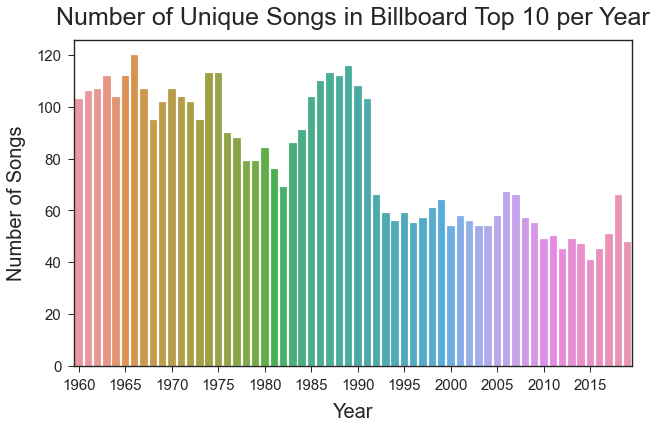

In [93]:
# graph number of unique songs per year
plt.figure(figsize=(10,6))
sns.barplot(x=df.year.value_counts().sort_index().index, y=df.year.value_counts().sort_index())
plt.title('Number of Unique Songs in Billboard Top 10 per Year', fontsize=25, pad=15)
plt.xlabel('Year', fontsize=20, labelpad=10)
plt.ylabel('Number of Songs', fontsize=20, labelpad=10)
plt.xticks(ticks=range(0,60,5), labels=range(1960,2021,5), fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Looks like I will have to account for class imbalance once I get to the modeling stage.

## Next notebook: [Data Cleaning](02_data_cleaning.ipynb)

[[go back to the top](#Webscraping)]

- The next notebook includes data cleaning and some more rescraping.

## STEPS FOR THE FUTURE (to optimize initial webscrape)

- Separate main artist and featured artists
- Replace "and"s in artist name with "&"